In [38]:
## IMPORTS
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.animation import FuncAnimation
import numpy as np

from kwave.kgrid import kWaveGrid
from kwave.kmedium import kWaveMedium
from kwave.ksensor import kSensor
from kwave.ksource import kSource
from kwave.kspaceFirstOrder2D import kspaceFirstOrder2D
from kwave.utils.signals import tone_burst
from kwave.kWaveSimulation import SimulationOptions
from kwave.options.simulation_execution_options import SimulationExecutionOptions
from kwave.utils.colormap import get_color_map

In [43]:
## SIMULATION SETUP
c0 = 1540                       # [m/s] Speed of sound
rho0 = 1000                     # [kg/m^3] Density of water
source_f0 = 1e6                 # [Hz] Source frequency
source_amp = 1e6                # [Pa] Source amplitude
source_cycles = 2              # Number of cycles in the pulse

grid_size_x = 40e-3             # [m] Grid size in x (NB: Depth in k-Wave)
grid_size_y = 40e-3             # [m] Grid size in z (NB: Width in k-Wave)
ppw = 10                         # Points per wavelength
cfl = 0.3                       # Related to the time resolution, lower is more accurate (no need to change)

viz_t = grid_size_y / 2 / c0 * 0.75      # Visualization time [s]


In [44]:
## SETUP AND RUN SIMULATION

# Setup Grid
dx = c0 / (ppw * source_f0)     # Grid resolution
Nx = round(grid_size_x / dx)    # Number of grid points in x, NB: This is depth
Ny = round(grid_size_y / dx)    # Number of grid points in y, NB: This is width (lateral)
kgrid = kWaveGrid([Nx, Ny], [dx, dx])
kgrid.makeTime(c0, cfl)         # Make time array based on the Courant-Friedrichs-Lewy (CFL) condition

# Setup source
# Source signal, Gaussian pulse
source_sig = source_amp * tone_burst(1 / kgrid.dt, source_f0, source_cycles)

# Define kWave source object
source = kSource()
source.p_mask = np.zeros_like(kgrid.x)
source.p_mask[round(kgrid.Nx/2), round(kgrid.Ny/2)] = 1     # Source position, centered in the grid
source.p = source_sig                                       # Source signal (pressure source)

# Setup sensor
sensor = kSensor(record=['p', 'p_max'])                     # Sensor object, record pressure and maximum pressure
sensor.mask = np.ones_like(kgrid.x)                         # Sensor mask, all grid points

# Setup medium
medium = kWaveMedium(sound_speed=c0, density=rho0)          # Define medium object, simple homogeneous medium

# Add varying speed of sound in medium
medium.sound_speed = np.ones_like(kgrid.x) * c0
medium.sound_speed[kgrid.Nx//2::, :] = c0 * 0.5

# Setup simulation options
simulation_options = SimulationOptions(
    pml_auto=True,
    pml_inside=False,
    save_to_disk=True,
    data_cast='single',
)
execution_options = SimulationExecutionOptions(is_gpu_simulation=False)

# Run 2D simulation (to save some time)
sensor_data = kspaceFirstOrder2D(kgrid=kgrid, medium=medium, source=source, sensor=sensor,
                                  simulation_options=simulation_options, execution_options=execution_options)

# Extract pressure field from
p_field = np.reshape(sensor_data["p"], (kgrid.Nt, Nx, Ny), order="F")   # Stored in Fortran ordering for some reason

┌───────────────────────────────────────────────────────────────┐
│                   kspaceFirstOrder-OMP v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Number of CPU threads:                                     16 │
│ Processor name: AMD Ryzen 7 PRO 7840U w/ Radeon 780M Graphics │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                                  288 x 288 │
│ Medium type:                                               2D │
│ Simulation time steps:                                   1226 │
├───────────────────────────────────────────────────────────────┤
│                        Initialization                         │
├───────────────────────────────────────────────────────────────┤
│ Memory a

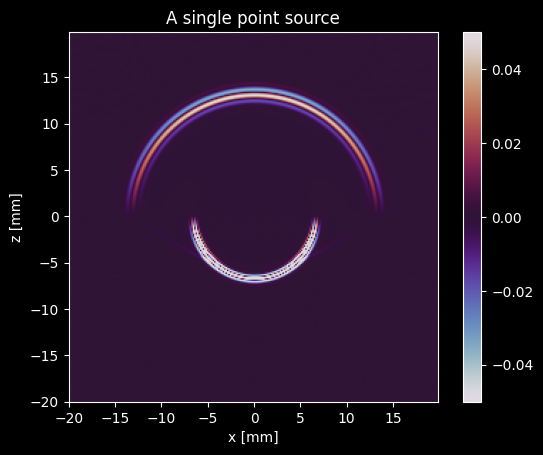

In [45]:
## VISUALIZATION
plt.style.use('dark_background')

# Get frame number to plot
viz_t = grid_size_y / 2 / c0 * 0.75      # Visualization time [s]
N_frame = np.round(np.where(kgrid.t_array[0] > viz_t)[0][0]).astype(int)   # Number of frames to visualize

# Normalize frames based on the maximum value over all frames
max_value = np.max(np.abs(p_field))
p_plot = p_field / max_value

cmap = 'twilight'
extent = np.array([kgrid.y_vec[0], kgrid.y_vec[-1], kgrid.x_vec[0], kgrid.x_vec[-1]])*1e3

# Create a figure and axis
fig, ax = plt.subplots()
image = plt.imshow(p_plot[N_frame], cmap=cmap, vmin=-0.05, vmax=0.05, extent=extent)
plt.colorbar()
plt.xlabel('x [mm]')
plt.ylabel('z [mm]')
plt.title('A single point source')
plt.show()

In [ ]:
# Create animation showing propagation over time
def update(frame):
    image.set_data(p_plot[frame])
    ax.set_title(f"Frame: {frame}/{kgrid.Nt}")
    return [image]

ANIM_START = 0
ANIM_END = kgrid.Nt - 150
ANIM_STEP = 10
ANIM_FILENAME = "task1_point_source_different_speeds.mp4"

animation = FuncAnimation(fig, update, frames=np.arange(ANIM_START, ANIM_END, ANIM_STEP), interval=100, blit=True)

from os import makedirs
makedirs(f"../output/4/", exist_ok=True)
animation.save(f"../output/4/{ANIM_FILENAME}", writer='ffmpeg', fps=30)


# Observations from changing parameters

Changing which frame to show lets us see the wave propagate over time from a single point to a wave.

## Changing grid size and resolution

Increasing the grid resolution (done by making `dx` smaller) gives us a more dense grid, which results in better resolution in the output frames, but also means running the simulation takes longer. Similarly, if we make the grid bigger, we can see the wave propagate further, but this also means running the simulation takes longer.
Reducing the number of points per wavelenght (`ppw`) makes the simulation run faster, but also gives less accurate results.

Changes to the number of cycles in the pulse (adjusting `source_cycles`) is visible in the simulation output vizualition where you can actually count the number of cycles directly (see how many times the color changes from blue to red, in this case).

## Changing speed of sound in the medium

By adjusting the values in `medium.sound_speed` (an array containing the speed of sound for every cell in the grid/medium) we can create regions where sound travels at different speeds. I have adjusted the medium so that the bottom half (`y < 0`) of the grid has a speed of sound half of `c0` (currently set to `1540m/s`). Since the point source is centered in the grid (`z=0, x=0`), this effectively means half of the wave is travelling in the *fast* medium while the other half is moving in the *slow* one.
The different speeds is very visible in the animation where you can actually see the wavefronts moving slower out of frame in the bottom half then it does in the top half.

